# Factor Analysis vs PCA: Educational Assessment Data

This analysis demonstrates both Factor Analysis (FA) and Principal Component Analysis (PCA)
on student assessment data to identify latent constructs and understand dimensionality.

**Learning objectives:**
- Apply Factor Analysis to discover latent psychological constructs
- Apply PCA to identify underlying dimensions in multivariate data
- Understand communalities and uniquenesses in measurement models
- Use factor rotation to achieve simple structure
- Compare Factor Analysis with Principal Component Analysis
- Interpret factor loadings for construct validation
- Understand the fundamental differences between FA and PCA

## Import Libraries and Setup

**Task:** Set up your Python environment for both Factor Analysis and PCA by importing the necessary libraries. You'll need:
- pandas for data handling
- numpy for numerical operations
- matplotlib and seaborn for visualization
- scikit-learn's PCA and StandardScaler
- factor_analyzer package (including FactorAnalyzer, calculate_kmo, and calculate_bartlett_sphericity)
- Configure a basic logger for tracking analysis steps

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Simple logger
import logging

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
logger = logging.getLogger(__name__)

## Data Loading and Exploration

**Task:** Load the educational assessment data from the CSV file in the current directory. Check if the file exists (if not, inform the user to run the fetch script and exit with code 1). Extract the assessment variables (excluding the Student ID column) and log basic information about the dataset dimensions and variable names.

In [2]:
script_dir = Path.cwd()
data_path = script_dir / "educational.csv"

if not data_path.exists():
    logger.error(f"Data file not found: {data_path}")
    logger.info("Run 'fetch_educational.py' to generate the required data file")
    sys.exit(1)

df = pd.read_csv(data_path)
logger.info(
    f"Loaded dataset: {len(df)} students, {len(df.columns) - 1} assessment variables"
)

# Extract assessment variables (exclude Student ID)
X = df.iloc[:, 1:]
variable_names = list(X.columns)

logger.info(f"Assessment variables: {variable_names}")
logger.info(f"Data shape: {X.shape}")

INFO: Loaded dataset: 100 students, 6 assessment variables
INFO: Assessment variables: ['MathTest', 'VerbalTest', 'SocialSkills', 'Leadership', 'RandomVar1', 'RandomVar2']
INFO: Data shape: (100, 6)


## Data Standardization

**Task:** Standardize the assessment data using StandardScaler so all variables have mean 0 and standard deviation 1. Log a confirmation message after standardization.

Both Factor Analysis and PCA require standardized data to ensure variables contribute equally
to the analysis, regardless of their original measurement scales.

In [3]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

logger.info("Data standardized: mean ≈ 0, std ≈ 1 for all variables")

INFO: Data standardized: mean ≈ 0, std ≈ 1 for all variables


## Factor Analysis Assumptions Testing

**Task:** Test the statistical assumptions for Factor Analysis by calculating Bartlett's Test of Sphericity and the Kaiser-Meyer-Olkin (KMO) measure of sampling adequacy. Log the chi-square statistic and p-value for Bartlett's test (with interpretation whether p < 0.05). For KMO, log the overall measure and classify it as Excellent (>0.9), Good (>0.8), Acceptable (>0.6), or Unacceptable.

Before proceeding with Factor Analysis, we must verify that our data meets
key statistical assumptions for meaningful factor extraction.

In [4]:
# Test statistical assumptions
chi_square_value, p_value = calculate_bartlett_sphericity(X_standardized)
kmo_all, kmo_model = calculate_kmo(X_standardized)

logger.info("Factor Analysis Assumptions Testing:")
logger.info("\nBartlett's Test of Sphericity:")
logger.info(f"  Chi-square statistic: {chi_square_value:.3f}")
logger.info(f"  p-value: {p_value:.6f}")
if p_value < 0.05:
    logger.info("  ✓ Significant - variables are sufficiently correlated for FA")
else:
    logger.info("  ✗ Not significant - FA may not be appropriate")

logger.info("\nKaiser-Meyer-Olkin (KMO) Test:")
logger.info(f"  Overall Measure of Sampling Adequacy: {kmo_model:.3f}")
if kmo_model > 0.9:
    adequacy = "Excellent"
elif kmo_model > 0.8:
    adequacy = "Good"
elif kmo_model > 0.6:
    adequacy = "Acceptable"
else:
    adequacy = "Unacceptable"
logger.info(f"  Interpretation: {adequacy} sampling adequacy")

INFO: Factor Analysis Assumptions Testing:
INFO: 
Bartlett's Test of Sphericity:
INFO:   Chi-square statistic: 1168.629
INFO:   p-value: 0.000000
INFO:   ✓ Significant - variables are sufficiently correlated for FA
INFO: 
Kaiser-Meyer-Olkin (KMO) Test:
INFO:   Overall Measure of Sampling Adequacy: 0.247
INFO:   Interpretation: Unacceptable sampling adequacy


### Individual Variable Adequacy

**Task:** Extract and log the individual KMO (Measure of Sampling Adequacy) value for each variable. Identify any variables with MSA < 0.6 and flag them as problematic, or confirm that all variables show adequate sampling adequacy.

Each variable's individual KMO value indicates how well it can be predicted
from the other variables in the analysis.

In [5]:
logger.info("\nIndividual Variable Sampling Adequacy:")
for i, var_name in enumerate(variable_names):
    msa_value = kmo_all[i]
    logger.info(f"  {var_name}: {msa_value:.3f}")

# Flag any problematic variables
low_msa_vars = [
    var_name for i, var_name in enumerate(variable_names) if kmo_all[i] < 0.6
]
if low_msa_vars:
    logger.warning(f"Variables with low MSA (<0.6): {low_msa_vars}")
else:
    logger.info("All variables show adequate sampling adequacy (MSA ≥ 0.6)")

INFO: 
Individual Variable Sampling Adequacy:
INFO:   MathTest: 0.239
INFO:   VerbalTest: 0.230
INFO:   SocialSkills: 0.235
INFO:   Leadership: 0.244
INFO:   RandomVar1: 0.906
INFO:   RandomVar2: 0.884


## Factor Extraction with Principal Axis Factoring

**Task:** Extract 2 factors using Principal Axis Factoring (method='principal') without rotation. Use the FactorAnalyzer class, fit it to the standardized data, and verify that the extraction succeeded by checking if loadings were produced. Log the eigenvalues for the extracted factors rounded to 3 decimal places.

We'll extract factors using Principal Axis Factoring (PAF), which:
- Focuses on shared variance among variables (common factors)
- Estimates communalities iteratively
- Distinguishes between common and unique variance

In [6]:
# Determine number of factors to extract
n_factors = 2  # Based on theoretical expectation of cognitive + social factors

fa_unrotated = FactorAnalyzer(n_factors=n_factors, rotation=None, method="principal")
fa_unrotated.fit(X_standardized)

# Verify successful extraction
if fa_unrotated.loadings_ is None:
    logger.error("Factor extraction failed - no loadings produced")
    sys.exit(1)

logger.info(f"Factor Analysis Results ({n_factors} factors extracted):")
eigenvalues_fa = fa_unrotated.get_eigenvalues()[0]
logger.info(f"Eigenvalues: {np.round(eigenvalues_fa[:n_factors], 3)}")

k:\ma2003b\ma2003b.worktrees\dev\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
INFO: Factor Analysis Results (2 factors extracted):
INFO: Eigenvalues: [2.201 1.852]


### Communalities and Variance Decomposition

**Task:** Extract the communalities from the factor analysis and calculate uniquenesses (1 - communality). For each variable, log its communality (h²) and uniqueness (u²) values rounded to 3 decimal places. Then calculate and log the total common variance (sum of communalities), the proportion of total variance explained by factors, and the average communality.

Each variable's variance is decomposed into:
- **Communality (h²)**: Variance explained by common factors
- **Uniqueness (u²)**: Variance unique to the variable (including error)

In [7]:
communalities = fa_unrotated.get_communalities()
uniquenesses = 1 - communalities

logger.info("\nVariance Decomposition (Communalities and Uniquenesses):")
for i, var_name in enumerate(variable_names):
    h2 = communalities[i]
    u2 = uniquenesses[i]
    logger.info(f"  {var_name}: h² = {h2:.3f}, u² = {u2:.3f}")

# Analyze overall variance structure
factor_variance = np.sum(communalities)
total_variance = len(variable_names)  # For standardized data
variance_explained_fa = factor_variance / total_variance

logger.info("\nOverall Variance Analysis:")
logger.info(f"Total standardized variance: {total_variance:.1f}")
logger.info(f"Common variance (Σh²): {factor_variance:.3f}")
logger.info(f"Proportion of variance explained by factors: {variance_explained_fa:.1%}")
logger.info(f"Average communality: {np.mean(communalities):.3f}")

INFO: 
Variance Decomposition (Communalities and Uniquenesses):
INFO:   MathTest: h² = 0.950, u² = 0.050
INFO:   VerbalTest: h² = 0.916, u² = 0.084
INFO:   SocialSkills: h² = 0.900, u² = 0.100
INFO:   Leadership: h² = 0.917, u² = 0.083
INFO:   RandomVar1: h² = 0.165, u² = 0.835
INFO:   RandomVar2: h² = 0.205, u² = 0.795
INFO: 
Overall Variance Analysis:
INFO: Total standardized variance: 6.0
INFO: Common variance (Σh²): 4.053
INFO: Proportion of variance explained by factors: 67.5%
INFO: Average communality: 0.675


**Interpreting Communalities:**

- **High communality (h² > 0.6)**: Variable strongly related to common factors
- **Moderate communality (0.3 < h² < 0.6)**: Moderate factor relationship
- **Low communality (h² < 0.3)**: Mostly unique variance, weak factor loading

Variables with very low communalities may be candidates for removal
or may represent additional factors not captured in the current solution.

## Factor Rotation for Simple Structure

**Task:** Extract 2 factors again using Principal Axis Factoring but this time with Varimax rotation. Store both the unrotated and rotated loadings matrices. Include a safety check in case rotation fails (use unrotated solution as fallback). Create a comparison DataFrame showing the unrotated and rotated loadings side-by-side for both factors, and display it rounded to 3 decimal places.

Factor rotation improves interpretability without changing the fundamental solution.
Varimax rotation seeks "simple structure" where each variable loads primarily on one factor.

In [8]:
fa_rotated = FactorAnalyzer(n_factors=n_factors, rotation="varimax", method="principal")
fa_rotated.fit(X_standardized)

loadings_unrotated = fa_unrotated.loadings_
loadings_rotated = fa_rotated.loadings_

# Safety check for rotation success
if loadings_rotated is None:
    logger.warning("Varimax rotation failed, using unrotated solution")
    loadings_rotated = loadings_unrotated
    fa_rotated = fa_unrotated

logger.info("\nFactor Loadings Comparison (Unrotated vs. Varimax Rotated):")

# Create comparison table
comparison_df = pd.DataFrame(
    {
        "Variable": variable_names,
        "Unrot_F1": loadings_unrotated[:, 0],
        "Unrot_F2": loadings_unrotated[:, 1],
        "Rotated_F1": loadings_rotated[:, 0],
        "Rotated_F2": loadings_rotated[:, 1],
    }
)

print(comparison_df.round(3))

k:\ma2003b\ma2003b.worktrees\dev\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
INFO: 
Factor Loadings Comparison (Unrotated vs. Varimax Rotated):


       Variable  Unrot_F1  Unrot_F2  Rotated_F1  Rotated_F2
0      MathTest    -0.681     0.698      -0.147       0.964
1    VerbalTest    -0.663     0.690      -0.137       0.947
2  SocialSkills     0.724     0.613       0.945       0.077
3    Leadership     0.791     0.539       0.957      -0.023
4    RandomVar1     0.384     0.133       0.390      -0.115
5    RandomVar2    -0.024    -0.452      -0.283      -0.354


### Factor Loading Interpretation

**Rotation benefits:**
- **Simple structure**: Variables load primarily on one factor
- **Clearer interpretation**: Easier to identify what each factor represents
- **Practical meaning**: Factors align better with theoretical constructs

**Loading interpretation guidelines:**
- **|loading| > 0.6**: Strong factor relationship
- **0.3 < |loading| < 0.6**: Moderate relationship
- **|loading| < 0.3**: Weak/negligible relationship

## Principal Component Analysis

**Task:** Apply PCA to the standardized data and transform it to obtain principal component scores. Extract the eigenvalues, explained variance ratios, and cumulative variance. Log these results rounded to 3 decimal places to understand how much variance each component captures.

PCA identifies linear combinations of variables that capture maximum variance.
Unlike Factor Analysis, PCA does not distinguish between common and unique variance.

In [9]:
pca = PCA()
Z = pca.fit_transform(X_standardized)

eigenvalues_pca = pca.explained_variance_
explained_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_ratio)

logger.info("\nPCA Results:")
logger.info(f"Eigenvalues: {np.round(eigenvalues_pca, 3)}")
logger.info(f"Explained variance ratio: {np.round(explained_ratio, 3)}")
logger.info(f"Cumulative variance: {np.round(cumulative_variance, 3)}")

INFO: 
PCA Results:
INFO: Eigenvalues: [2.223 1.87  0.97  0.862 0.134 0.   ]
INFO: Explained variance ratio: [0.367 0.309 0.16  0.142 0.022 0.   ]
INFO: Cumulative variance: [0.367 0.675 0.836 0.978 1.    1.   ]


### Interpreting the Variance Structure

The eigenvalues and explained variance ratios reveal the underlying dimensionality:

**Key insights:**
- **PC1**: Captures the largest amount of variance, likely representing general academic ability
- **PC2**: Secondary dimension, possibly distinguishing cognitive vs. social skills
- **Later components**: May capture measurement noise or minor skill variations
- **Cumulative variance**: Shows how much total information is retained with each component

**Component retention strategy:**
- Kaiser criterion: Retain components with eigenvalues > 1.0
- Scree plot: Look for the "elbow" where eigenvalues level off
- Practical rule: Retain components explaining ≥80% cumulative variance

## Eigenvalue Comparison: FA vs PCA

**Task:** Create two side-by-side scree plots comparing PCA eigenvalues (left, in steelblue) with FA eigenvalues (right, in darkgreen). For each plot, show eigenvalues as connected points, add a horizontal line at eigenvalue = 1.0 (Kaiser criterion), include proper axis labels and titles, and add a grid. Save the combined figure as 'fa_scree.png'.

Scree plots reveal how eigenvalues differ between methods due to their
different approaches to variance decomposition.

INFO: Eigenvalue comparison saved: k:\ma2003b\ma2003b.worktrees\dev\lessons\ch4_Factor_Analysis\examples\educational_example\fa_scree.png


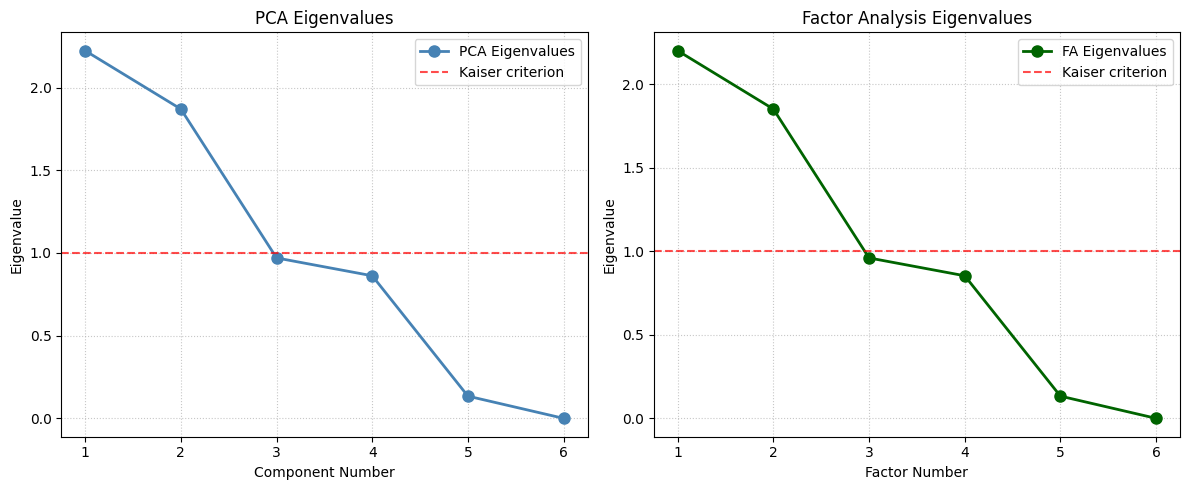

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
components = np.arange(1, len(eigenvalues_pca) + 1)

# PCA scree plot
ax1.plot(
    components,
    eigenvalues_pca,
    "o-",
    linewidth=2,
    color="steelblue",
    markersize=8,
    label="PCA Eigenvalues",
)
ax1.axhline(y=1.0, color="red", linestyle="--", alpha=0.7, label="Kaiser criterion")
ax1.set_xlabel("Component Number")
ax1.set_ylabel("Eigenvalue")
ax1.set_title("PCA Eigenvalues")
ax1.set_xticks(components)
ax1.grid(True, linestyle=":", alpha=0.7)
ax1.legend()

# FA scree plot
ax2.plot(
    components,
    eigenvalues_fa,
    "o-",
    linewidth=2,
    color="darkgreen",
    markersize=8,
    label="FA Eigenvalues",
)
ax2.axhline(y=1.0, color="red", linestyle="--", alpha=0.7, label="Kaiser criterion")
ax2.set_xlabel("Factor Number")
ax2.set_ylabel("Eigenvalue")
ax2.set_title("Factor Analysis Eigenvalues")
ax2.set_xticks(components)
ax2.grid(True, linestyle=":", alpha=0.7)
ax2.legend()

plt.tight_layout()
scree_path = script_dir / "fa_scree.png"
plt.savefig(scree_path, dpi=150, bbox_inches="tight")
logger.info(f"Eigenvalue comparison saved: {scree_path}")
plt.show()

**Eigenvalue pattern differences:**

- **FA eigenvalues**: Generally lower because they reflect only common variance
- **PCA eigenvalues**: Higher because they include both common and unique variance
- **Kaiser criterion**: May suggest different optimal numbers for FA vs PCA
- **Theoretical focus**: FA prioritizes meaningful factors over variance maximization

## Factor Loading Visualization

**Task:** Create a side-by-side comparison of two heatmaps showing unrotated and Varimax rotated factor loadings. Use matplotlib's imshow with the 'RdBu_r' colormap (range -1 to 1). Label the x-axis with variable names (rotated 45 degrees), y-axis with factor numbers. Add text annotations showing the exact loading values (rounded to 3 decimals) in each cell. Include a shared colorbar on the right side of the figure. Save the figure as 'fa_loadings.png'.

Heatmaps provide visual comparison of loading patterns before and after rotation.

INFO: Factor loadings heatmap saved: k:\ma2003b\ma2003b.worktrees\dev\lessons\ch4_Factor_Analysis\examples\educational_example\fa_loadings.png


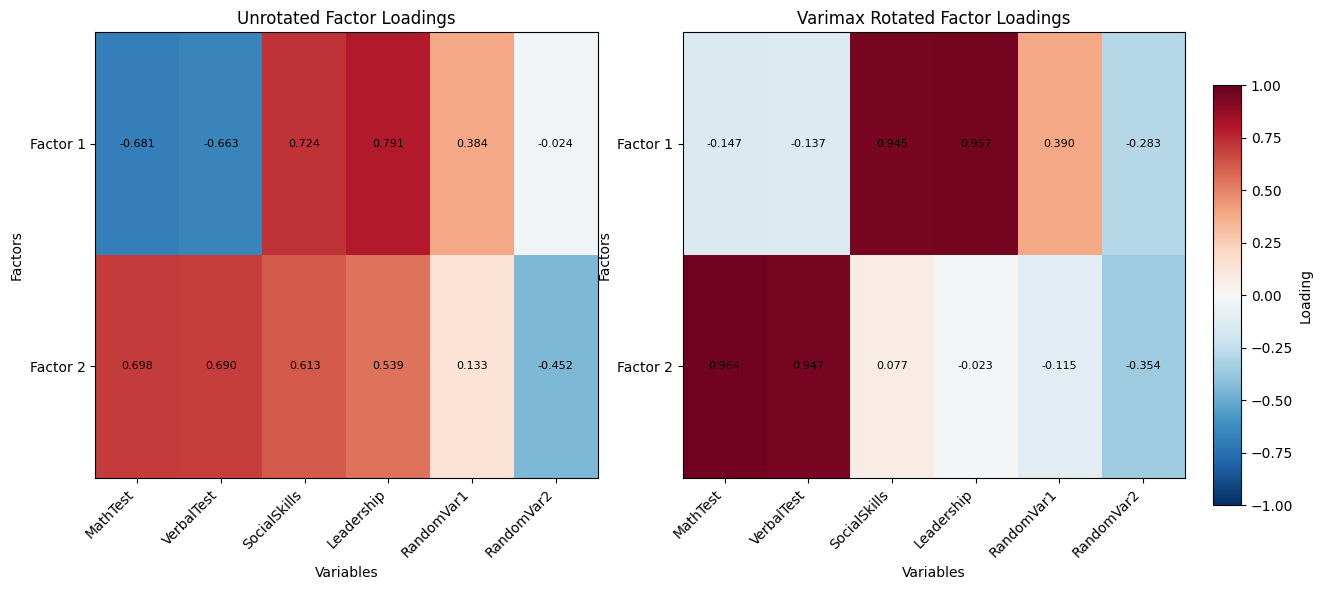

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Unrotated loadings heatmap using matplotlib imshow
im1 = ax1.imshow(
    loadings_unrotated.T,
    cmap="RdBu_r",
    aspect="auto",
    vmin=-1,
    vmax=1,
)
ax1.set_title("Unrotated Factor Loadings")
ax1.set_xlabel("Variables")
ax1.set_ylabel("Factors")
ax1.set_xticks(range(len(variable_names)))
ax1.set_xticklabels(variable_names, rotation=45, ha="right")
ax1.set_yticks(range(n_factors))
ax1.set_yticklabels([f"Factor {i + 1}" for i in range(n_factors)])

# Add annotations
for i in range(n_factors):
    for j in range(len(variable_names)):
        text = ax1.text(
            j,
            i,
            f"{loadings_unrotated[j, i]:.3f}",
            ha="center",
            va="center",
            color="black",
            fontsize=8,
        )

# Rotated loadings heatmap using matplotlib imshow
im2 = ax2.imshow(
    loadings_rotated.T,
    cmap="RdBu_r",
    aspect="auto",
    vmin=-1,
    vmax=1,
)
ax2.set_title("Varimax Rotated Factor Loadings")
ax2.set_xlabel("Variables")
ax2.set_ylabel("Factors")
ax2.set_xticks(range(len(variable_names)))
ax2.set_xticklabels(variable_names, rotation=45, ha="right")
ax2.set_yticks(range(n_factors))
ax2.set_yticklabels([f"Factor {i + 1}" for i in range(n_factors)])

# Add annotations
for i in range(n_factors):
    for j in range(len(variable_names)):
        text = ax2.text(
            j,
            i,
            f"{loadings_rotated[j, i]:.3f}",
            ha="center",
            va="center",
            color="black",
            fontsize=8,
        )

# Adjust layout and add colorbar to the right
plt.tight_layout()
fig.subplots_adjust(right=0.85)  # Make room for colorbar
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # Position for colorbar
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Loading")

loadings_path = script_dir / "fa_loadings.png"
plt.savefig(loadings_path, dpi=150, bbox_inches="tight")
logger.info(f"Factor loadings heatmap saved: {loadings_path}")
plt.show()

## PCA Biplot Visualization

**Task:** Create a PCA biplot combining student scores on PC1 and PC2 (as colored scatter points) with variable loadings (as red arrows emanating from the origin). Scale the loading arrows appropriately so they're visible on the same plot. Color the points by their PC1 score using a colormap. Include axis labels showing the variance explained by each component. Save the plot as 'pca_biplot.png'.

The biplot combines:
- **Points**: Individual student scores on PC1 and PC2
- **Arrows**: Variable loadings showing how each assessment contributes to the components

**Interpretation guide:**
- Arrow direction indicates which component the variable loads on
- Arrow length indicates loading strength
- Similar arrows suggest variables measure related constructs
- Opposite arrows indicate negative correlation

INFO: Biplot saved: k:\ma2003b\ma2003b.worktrees\dev\lessons\ch4_Factor_Analysis\examples\educational_example\pca_biplot.png


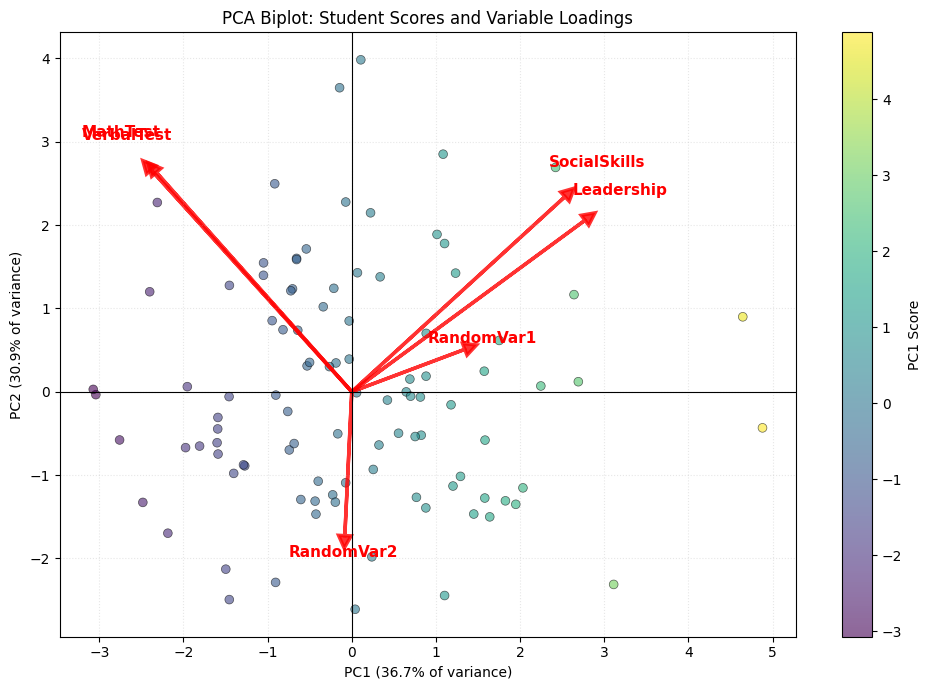

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))

# Plot student scores
pc1_scores = Z[:, 0]
pc2_scores = Z[:, 1]

scatter = ax.scatter(
    pc1_scores,
    pc2_scores,
    c=pc1_scores,
    cmap="viridis",
    alpha=0.6,
    s=40,
    edgecolors="black",
    linewidth=0.5,
)
colorbar = plt.colorbar(scatter, label="PC1 Score")

# Plot variable loadings as arrows
pca_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
scale_factor = max(pc1_scores.std(), pc2_scores.std()) * 3.5

for i, var_name in enumerate(variable_names):
    loading_x = pca_loadings[i, 0] / np.sqrt(pca.explained_variance_[0]) * scale_factor
    loading_y = pca_loadings[i, 1] / np.sqrt(pca.explained_variance_[1]) * scale_factor

    ax.arrow(
        0,
        0,
        loading_x,
        loading_y,
        color="red",
        head_width=0.15,
        alpha=0.8,
        linewidth=2.5,
        head_length=0.15,
    )
    ax.text(
        loading_x * 1.15,
        loading_y * 1.15,
        var_name,
        color="red",
        fontweight="bold",
        fontsize=11,
        ha="center",
    )

ax.set_xlabel(f"PC1 ({explained_ratio[0]:.1%} of variance)")
ax.set_ylabel(f"PC2 ({explained_ratio[1]:.1%} of variance)")
ax.set_title("PCA Biplot: Student Scores and Variable Loadings")
ax.grid(True, linestyle=":", alpha=0.3)
ax.axhline(y=0, color="black", linewidth=0.8)
ax.axvline(x=0, color="black", linewidth=0.8)

plt.tight_layout()
biplot_path = script_dir / "pca_biplot.png"
plt.savefig(biplot_path, dpi=150, bbox_inches="tight")
logger.info(f"Biplot saved: {biplot_path}")
plt.show()

## Factor Analysis vs PCA Comparison

**Task:** Compare the variance explanation: calculate the proportion of total variance explained by the first 2 PCA components vs. the proportion of common variance explained by 2 FA factors. Get factor scores from the rotated FA model. Create a comparison DataFrame showing PCA loadings (PC1, PC2) and FA loadings (F1, F2) side-by-side for all variables. Display rounded to 3 decimals.

Direct comparison reveals fundamental differences between these two approaches
to multivariate data analysis.

In [13]:
# Get factor scores
fa_scores = fa_rotated.transform(X_standardized)

logger.info("\nFactor Analysis vs PCA Comparison:")

# Variance explanation comparison
pca_variance_2comp = explained_ratio[:2].sum()
logger.info("\nVariance Explanation:")
logger.info(f"  PCA (first 2 components): {pca_variance_2comp:.1%} of total variance")
logger.info(f"  FA (2 factors): {variance_explained_fa:.1%} of common variance")
logger.info(
    "  Key difference: PCA maximizes total variance, FA focuses on shared variance"
)

# Loading comparison
logger.info("\nLoading Pattern Comparison:")
comparison_detailed = pd.DataFrame(
    {
        "Variable": variable_names,
        "PCA_PC1": pca_loadings[:, 0],
        "PCA_PC2": pca_loadings[:, 1],
        "FA_F1": loadings_rotated[:, 0],
        "FA_F2": loadings_rotated[:, 1],
    }
)

print(comparison_detailed.round(3))

k:\ma2003b\ma2003b.worktrees\dev\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
INFO: 
Factor Analysis vs PCA Comparison:
INFO: 
Variance Explanation:
INFO:   PCA (first 2 components): 67.5% of total variance
INFO:   FA (2 factors): 67.5% of common variance
INFO:   Key difference: PCA maximizes total variance, FA focuses on shared variance
INFO: 
Loading Pattern Comparison:


       Variable  PCA_PC1  PCA_PC2  FA_F1  FA_F2
0      MathTest   -0.684    0.701 -0.147  0.964
1    VerbalTest   -0.667    0.693 -0.137  0.947
2  SocialSkills    0.727    0.616  0.945  0.077
3    Leadership    0.795    0.542  0.957 -0.023
4    RandomVar1    0.386    0.134  0.390 -0.115
5    RandomVar2   -0.024   -0.455 -0.283 -0.354


## Factor Structure Interpretation and Validation

**Task:** Analyze the rotated factor structure by identifying salient loadings (absolute value > 0.4) for each factor. Log which variables load strongly on each factor with their loading values. Then perform a communality pattern analysis: calculate the mean communality for meaningful variables (MathTest, VerbalTest, SocialSkills, Leadership) vs. random variables (RandomVar1, RandomVar2). Determine if the factor structure successfully distinguishes signal from noise (meaningful mean h² > 1.5 × random mean h²).

Analyze the extracted factors to understand what psychological constructs
they represent and how well they align with theoretical expectations.

In [14]:
# Identify salient loadings (commonly |loading| > 0.4)
loading_threshold = 0.4

logger.info(f"\nFactor Structure Analysis (threshold = {loading_threshold}):")
for factor_idx in range(n_factors):
    factor_name = f"Factor {factor_idx + 1}"
    salient_vars = []

    for var_idx, var_name in enumerate(variable_names):
        loading = loadings_rotated[var_idx, factor_idx]
        if abs(loading) > loading_threshold:
            salient_vars.append(f"{var_name} ({loading:+.3f})")

    logger.info(
        f"  {factor_name}: {', '.join(salient_vars) if salient_vars else 'No salient loadings'}"
    )

# Analyze communality patterns
meaningful_vars = ["MathTest", "VerbalTest", "SocialSkills", "Leadership"]
random_vars = ["RandomVar1", "RandomVar2"]

if all(var in variable_names for var in meaningful_vars + random_vars):
    meaningful_h2 = [
        communalities[variable_names.index(var)] for var in meaningful_vars
    ]
    random_h2 = [communalities[variable_names.index(var)] for var in random_vars]

    logger.info("\nCommunality Pattern Analysis:")
    logger.info(
        f"  Meaningful variables (cognitive/social): mean h² = {np.mean(meaningful_h2):.3f}"
    )
    logger.info(f"  Random variables (noise): mean h² = {np.mean(random_h2):.3f}")

    if np.mean(meaningful_h2) > np.mean(random_h2) * 1.5:
        logger.info("  ✓ Factor structure successfully distinguishes signal from noise")
    else:
        logger.info(
            "  ⚠ Mixed signal-noise separation - consider alternative solutions"
        )
else:
    logger.info("\nExpected variable names not found - skipping pattern analysis")

INFO: 
Factor Structure Analysis (threshold = 0.4):
INFO:   Factor 1: SocialSkills (+0.945), Leadership (+0.957)
INFO:   Factor 2: MathTest (+0.964), VerbalTest (+0.947)
INFO: 
Communality Pattern Analysis:
INFO:   Meaningful variables (cognitive/social): mean h² = 0.921
INFO:   Random variables (noise): mean h² = 0.185
INFO:   ✓ Factor structure successfully distinguishes signal from noise


## PCA Component Loadings Analysis

**Task:** Create a DataFrame showing the PCA loadings (component coefficients) for the first 3 principal components. Use the variable names as row labels and 'PC1', 'PC2', 'PC3' as column names. Display the loadings table rounded to 3 decimal places.

Loadings show how each variable contributes to each principal component.
High absolute loadings indicate strong relationships.

In [15]:
# Create loadings table for first 3 components
pca_loadings_df = pd.DataFrame(
    pca.components_[:3].T, columns=["PC1", "PC2", "PC3"], index=variable_names
)

logger.info("\nPCA Component Loadings Matrix:")
print(pca_loadings_df.round(3))

INFO: 
PCA Component Loadings Matrix:


                PC1    PC2    PC3
MathTest     -0.459  0.513 -0.078
VerbalTest   -0.447  0.507 -0.043
SocialSkills  0.488  0.451 -0.266
Leadership    0.533  0.396 -0.224
RandomVar1    0.259  0.098  0.712
RandomVar2   -0.016 -0.332 -0.603


## Student Score Analysis

**Task:** Create a DataFrame containing student IDs with their PC1 and PC2 scores. Identify and log the top 5 students with the highest scores on PC1, showing both their PC1 and PC2 values rounded to 3 decimal places.

Examine how students rank on the principal components to understand
the practical meaning of each dimension.

In [16]:
# Create student ranking analysis
student_scores = pd.DataFrame(
    {"Student_ID": range(1, len(df) + 1), "PC1_Score": Z[:, 0], "PC2_Score": Z[:, 1]}
)

# Top performers on PC1
top_pc1 = student_scores.nlargest(5, "PC1_Score")
logger.info("\nTop 5 students on PC1:")
for _, row in top_pc1.iterrows():
    logger.info(
        f"  Student {int(row['Student_ID'])}: PC1={row['PC1_Score']:.3f}, PC2={row['PC2_Score']:.3f}"
    )

# Top performers on PC2
top_pc2 = student_scores.nlargest(5, "PC2_Score")
logger.info("\nTop 5 students on PC2:")
for _, row in top_pc2.iterrows():
    logger.info(
        f"  Student {int(row['Student_ID'])}: PC1={row['PC1_Score']:.3f}, PC2={row['PC2_Score']:.3f}"
    )

# Score distribution summary
logger.info("\nScore Distribution Summary:")
logger.info(f"  PC1 range: [{Z[:, 0].min():.3f}, {Z[:, 0].max():.3f}]")
logger.info(f"  PC2 range: [{Z[:, 1].min():.3f}, {Z[:, 1].max():.3f}]")
logger.info(
    f"  PC1-PC2 correlation: {np.corrcoef(Z[:, 0], Z[:, 1])[0, 1]:.3f} (should be ≈ 0)"
)

INFO: 
Top 5 students on PC1:
INFO:   Student 80: PC1=4.879, PC2=-0.433
INFO:   Student 14: PC1=4.645, PC2=0.899
INFO:   Student 75: PC1=3.111, PC2=-2.312
INFO:   Student 36: PC1=2.692, PC2=0.121
INFO:   Student 57: PC1=2.640, PC2=1.165
INFO: 
Top 5 students on PC2:
INFO:   Student 7: PC1=0.107, PC2=3.983
INFO:   Student 21: PC1=-0.145, PC2=3.648
INFO:   Student 68: PC1=1.085, PC2=2.851
INFO:   Student 26: PC1=2.421, PC2=2.692
INFO:   Student 74: PC1=-0.915, PC2=2.496
INFO: 
Score Distribution Summary:
INFO:   PC1 range: [-3.071, 4.879]
INFO:   PC2 range: [-2.610, 3.983]
INFO:   PC1-PC2 correlation: -0.000 (should be ≈ 0)


## Summary and Method Selection Guidelines

This comparative analysis demonstrates key concepts for dimensionality reduction and latent variable modeling:

**Factor Analysis advantages:**
- **Theoretical grounding**: Models specific latent constructs (cognitive, social abilities)
- **Measurement model**: Separates common variance from measurement error
- **Simple structure**: Rotation achieves cleaner variable-factor relationships
- **Communality estimates**: Reveals how much variance is shared vs. unique

**PCA advantages:**
- **Maximum variance**: Captures the most information in each component
- **Data reduction**: Efficient compression for visualization and further analysis
- **Computational simplicity**: Faster and more stable than iterative FA
- **Total variance**: Includes all sources of variation (common + unique)

**When to choose Factor Analysis:**
- Testing specific theories about latent psychological constructs
- Developing or validating measurement instruments
- Modeling common variance while acknowledging measurement error
- Interpreting results in terms of theoretical constructs

**When to choose PCA instead:**
- Primary goal is data reduction or compression
- Maximizing explained variance is the priority
- No theoretical model for underlying structure
- Computational efficiency is critical

**Key methodological insights:**
- **Assumption testing**: KMO and Bartlett's tests confirm FA appropriateness
- **Rotation benefits**: Varimax rotation dramatically improves interpretability in FA
- **Communality interpretation**: FA distinguishes reliable measurement from noise
- **Variance focus**: PCA explains more total variance, FA focuses on shared variance
- **Construct validation**: Loading patterns should align with theoretical expectations

**Next applications:**
- Explore oblique rotation when factors may be correlated
- Use confirmatory factor analysis to test specific theoretical models
- Apply discriminant analysis for classification tasks
- Combine with cluster analysis to identify student groups
- Use canonical correlation to relate assessment domains